In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import random
import torch
import time
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramClassifier
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

## Load the Model

In [2]:
root = '/home/david/projects/university/astnn/data/'

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 104
EPOCHS = 15
BATCH_SIZE = 1
USE_GPU = False
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]

model = BatchProgramClassifier(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                               USE_GPU, embeddings)
model.load_state_dict(torch.load("/home/david/projects/university/astnn/model.pt"))

<All keys matched successfully>

In [3]:
word2vec = Word2Vec.load('/home/david/projects/university/astnn/data/train/embedding/node_w2v_128').wv
vocab = word2vec.vocab

In [4]:
print(model)
# print(model._modules['encoder'])

BatchProgramClassifier(
  (encoder): BatchTreeEncoder(
    (embedding): Embedding(8189, 128)
    (W_c): Linear(in_features=128, out_features=128, bias=True)
    (W_l): Linear(in_features=128, out_features=128, bias=True)
    (W_r): Linear(in_features=128, out_features=128, bias=True)
  )
  (root2label): Linear(in_features=128, out_features=104, bias=True)
  (bigru): GRU(128, 100, batch_first=True, bidirectional=True)
  (hidden2label): Linear(in_features=200, out_features=104, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Load some data

In [5]:
ast_data = pd.read_pickle(root+'test/test_.pkl')
block_data = pd.read_pickle(root+'test/blocks.pkl')

In [6]:
ast_data.head(n=10)

,id,code,label
45281,45281,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",3
40377,40377,"FileAST(ext=[Decl(name='s',\n ...",64
3220,3220,"FileAST(ext=[Decl(name='B',\n ...",90
20981,20981,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",98
36621,36621,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",26
29203,29203,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",53
15031,15031,"FileAST(ext=[Decl(name=None,\n ...",31
26307,26307,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",11
12163,12163,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",71
19003,19003,"FileAST(ext=[FuncDef(decl=Decl(name='sushu',\n...",68


In [7]:
block_data.head()

,id,code,label
45281,45281,"[[32, [2, [30, [40, [4]]]]], [6], [2, [13, [4]...",3
40377,40377,"[[32, [2, [30, [40, [81]]]]], [6], [2, [13, [4...",64
3220,3220,"[[32, [2, [30, [40, [4]]]]], [6], [2, [45, [4]...",90
20981,20981,"[[32, [2, [30, [40, [4]]]]], [6], [2, [23, [23...",98
36621,36621,"[[32, [2, [30, [40, [4]]]]], [6], [2, [0, [4]]...",26


An example record

In [264]:
x = block_data['code'][45281]
# x = block_data['code'][40377]
# x = block_data['code'][3220]
# x = block_data['code'][20981]

x

[[32, [2, [30, [40, [4]]]]],
 [6],
 [2, [13, [4]]],
 [2, [22, [4]]],
 [2, [23, [24, [4]], [92]]],
 [2, [0, [4]]],
 [2, [8, [4]]],
 [11, [36], [12, [156], [29, [13]], [29, [22]]]],
 [16, [3, [0], [5]], [20, [0], [13]], [14, [0]]],
 [11, [36], [12, [46], [29, [1, [24], [0]]]]],
 [16, [3, [0], [5]], [20, [0], [13]], [14, [0]]],
 [6],
 [16, [3, [8], [17, [0], [10]]], [20, [8], [13]], [14, [8]]],
 [15, [19, [17, [1, [24], [0]], [1, [24], [8]]], [22]]],
 [52],
 [15, [44, [8], [13]]],
 [52],
 [7],
 [15, [19, [0], [13]]],
 [11, [25], [12, [196]]],
 [11, [25], [12, [279]]],
 [39, [5]],
 [7]]

Elements represent indices of tokens in the word embedding

In [265]:
def index_to_token(node):
    i = node[0]
    result = [word2vec.index2word[i]]
    children = node[1:]
    for child in children:
        result.append(index_to_token(child))
    return result

token_blocks = []
for block in x:
    token_blocks.append(index_to_token(block))
    
token_blocks

[['FuncDef', ['Decl', ['FuncDecl', ['main', ['int']]]]],
 ['Compound'],
 ['Decl', ['n', ['int']]],
 ['Decl', ['k', ['int']]],
 ['Decl', ['ArrayDecl', ['m', ['int']], ['1000']]],
 ['Decl', ['i', ['int']]],
 ['Decl', ['j', ['int']]],
 ['FuncCall', ['scanf'], ['ExprList', ['"%d%d"'], ['&', ['n']], ['&', ['k']]]],
 ['For', ['=', ['i'], ['0']], ['<', ['i'], ['n']], ['++', ['i']]],
 ['FuncCall',
  ['scanf'],
  ['ExprList', ['"%d"'], ['&', ['ArrayRef', ['m'], ['i']]]]],
 ['For', ['=', ['i'], ['0']], ['<', ['i'], ['n']], ['++', ['i']]],
 ['Compound'],
 ['For',
  ['=', ['j'], ['+', ['i'], ['1']]],
  ['<', ['j'], ['n']],
  ['++', ['j']]],
 ['If',
  ['==',
   ['+', ['ArrayRef', ['m'], ['i']], ['ArrayRef', ['m'], ['j']]],
   ['k']]],
 ['Break'],
 ['If', ['!=', ['j'], ['n']]],
 ['Break'],
 ['End'],
 ['If', ['==', ['i'], ['n']]],
 ['FuncCall', ['printf'], ['ExprList', ['"no"']]],
 ['FuncCall', ['printf'], ['ExprList', ['"yes"']]],
 ['Return', ['0']],
 ['End']]

What do these statement trees look like

In [266]:
import networkx as nx

def add_to_graph(G, block, pi, label_dict):
    token = block[0]
    i = len(G)
    G.add_nodes_from([(i, {'label': token})])
    label_dict[i] = token
    
    if pi != None:
        G.add_edge(pi, i)
    
    children = block[1:]
    for child in children:
        add_to_graph(G, child, i, label_dict)

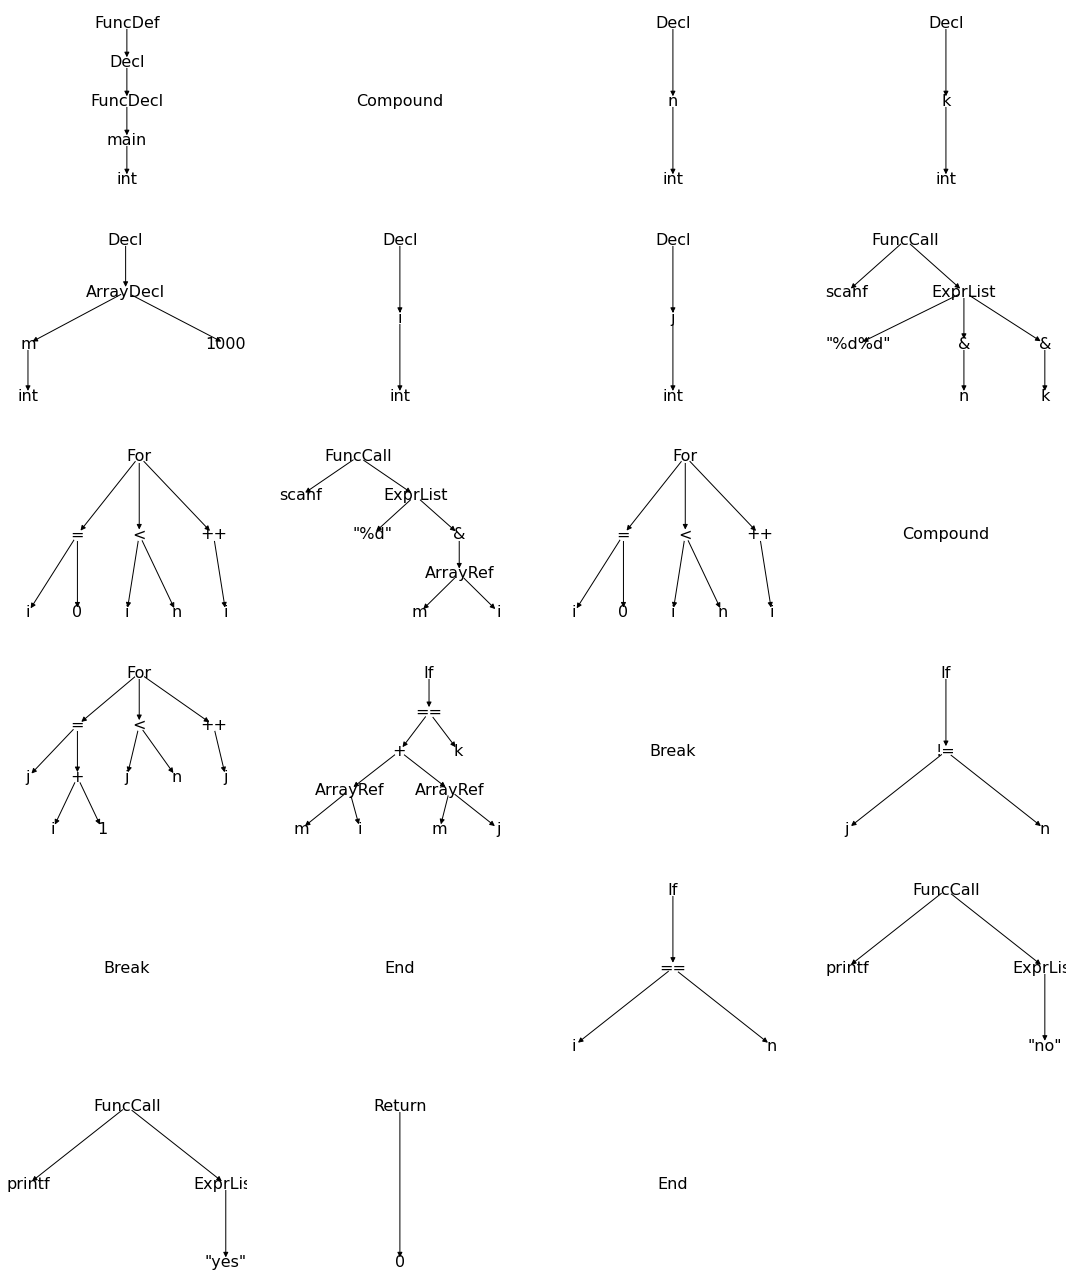

In [267]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

plt.figure(figsize=(15,30))

options = {
    'node_color': 'white',
    'node_size': 100,
    'width': 1,
    'font_size': 16
}

for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)


Need a method to find all the embedding locations

And the source code

In [268]:
from pycparser import c_ast, c_parser, c_generator

parser = c_parser.CParser()
generator = c_generator.CGenerator()


ast = ast_data['code'][45281]
print(generator.visit(ast))

int main()
{
  int n;
  int k;
  int m[1000];
  int i;
  int j;
  scanf("%d%d", &n, &k);
  for (i = 0; i < n; i++)
    scanf("%d", &m[i]);

  for (i = 0; i < n; i++)
  {
    for (j = i + 1; j < n; j++)
      if ((m[i] + m[j]) == k)
      break;


    if (j != n)
      break;

  }

  if (i == n)
    printf("no");
  else
    printf("yes");

  return 0;
}




Example grad calculation

In [13]:
loss_function = torch.nn.CrossEntropyLoss()

labels = torch.LongTensor([2])
output = model([x])
loss = loss_function(output, Variable(labels))
# for l in model._modules['encoder'].embedding_list:
#     l.retain_grad()
loss.backward()

Node List represents the node embeddings

In [14]:
n_list = model._modules['encoder'].node_list
n_list.size()

torch.Size([30, 40, 128])

In [15]:
n_list[9, 8, :]

tensor([ 0.0886,  0.3342, -0.0391,  0.0585, -0.2617, -0.0129, -0.1494,  0.0847,
        -0.0541,  0.0189, -0.1455, -0.2207,  0.0648, -0.3418, -0.0716, -0.0146,
        -0.1627,  0.0920, -0.0537, -0.0202,  0.1274,  0.0676,  0.2306,  0.3794,
         0.0046, -0.1069, -0.0423,  0.0416,  0.2585,  0.1606,  0.1809, -0.0159,
        -0.1239, -0.0580, -0.0411, -0.2278, -0.0976,  0.1598, -0.0224, -0.0793,
        -0.1512,  0.1437, -0.1775,  0.2297,  0.0308, -0.0439, -0.1341,  0.5539,
         0.0791,  0.0633,  0.0716,  0.2984, -0.3523,  0.0526, -0.2799, -0.2461,
        -0.0958, -0.1202,  0.1394,  0.0545, -0.1192, -0.1094, -0.0839, -0.1380,
        -0.0481,  0.0772,  0.0614,  0.1823, -0.0156, -0.2508,  0.0063, -0.0403,
        -0.0419,  0.0096,  0.0566,  0.2409, -0.3031, -0.2118, -0.0230,  0.1068,
         0.2479,  0.0874,  0.1073,  0.1014, -0.2089, -0.0640, -0.0603, -0.0994,
         0.1456, -0.0366,  0.1137,  0.1508,  0.0497, -0.0187, -0.1409, -0.1175,
         0.1116,  0.0047,  0.1167,  0.03

- 128: embedding dimension of the node
- 23: dimension for each block (statement tree)
- 22: dimension for node position in the statement tree

## Generate the embeddings for our vocab

Construct embedder for leaf nodes

In [16]:
leaf_embed = nn.Sequential(
    model._modules['encoder']._modules['embedding'],
    model._modules['encoder']._modules['W_c']
)

define rules for allowed variables

In [17]:
# words we wont allow as variable names
reserved_words = [
    'auto',
    'break',
    'case',
    'char',
    'const',
    'continue',
    'default',
    'do',
    'int',
    'long',
    'register',
    'return',
    'short',
    'sizeof',
    'static',
    'struct',
    'switch',
    'typedef',
    'union',
    'unsigned',
    'void',
    'volatile',
    'while',
    'double',
    'else',
    'enum',
    'extern',
    'float',
    'for',
    'goto',
    'if',
    'printf',
    'scanf',
    'cos',
    'malloc'
]

import re

def allowed_variable(var):
    pattern = re.compile("([a-z]|[A-Z]|_)+([a-z]|[A-Z]|[0-9]|_)*$")
    if (var not in reserved_words) and pattern.match(var):
        return True
    else:
        return False

allowed_variable('scanf')

False

In [269]:

embedding_map = {}

for index in range(len(vocab)):
    if allowed_variable(word2vec.index2word[index]):
        embedding_map[index] = leaf_embed(torch.tensor(index)).detach().numpy()

In [272]:
print("Our allowed variable vocab has length ", len(embedding_map))

Our allowed variable vocab has length  6960


## Functions used to replace a variable name

In [19]:
def replace_index(node, old_i, new_i):
    i = node[0]
    if i == old_i:
        result = [new_i]
    else:
        result = [i]
    children = node[1:]
    for child in children:
        result.append(replace_index(child, old_i, new_i))
    return result

def replace_var(x, old_i, new_i):
    mod_blocks = []
    for block in x:
        mod_blocks.append(replace_index(block, old_i, new_i))

    return mod_blocks

## Functions to get the closest variable

In [20]:
def l2_norm(a, b):
    return np.linalg.norm(a-b)

def cos_sim(a, b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def closest_index(embedding, embedding_map, metric):
    closest_i = 0
#     closest_dist = l2_norm(embedding_map[closest_i], embedding)
    closest_dist = metric(embedding_map[closest_i], embedding)
    for i, e in embedding_map.items():
#         d = l2_norm(embedding_map[i], embedding)
        d = metric(embedding_map[i], embedding)
        if d < closest_dist:
            closest_dist = d
            closest_i = i
    return closest_i

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

## Functions to get the gradients

In [21]:
def get_embedding(indices, node_list):
    '''
    get the embedding at the index position in postorder traversal.
    '''
    res = []
    c = 0
    for i in range(node_list.size(0)):
        if not np.all(node_list[i].detach().numpy() == 0):
            if c in indices:
                res.append(node_list[i])
            c += 1
    return res

def post_order_loc(node, var, res, counter):
    index = node[0]
    children = node[1:]
    for child in children:
        res, counter = post_order_loc(child, var, res, counter)
    if var == index and (not children):
        res.append(counter) 
#         print(counter, word2vec.index2word[index])
    counter += 1
    return res, counter

## Pick our example

modify $v$ to $v + \epsilon g$

In [258]:
def get_grad(x, var_index, node_list):
    grads = []
    for i, block in enumerate(x):
        indices, _ = post_order_loc(block, var_index, [], 0)
        grads += get_embedding(indices, node_list.grad[:, i, :])
        try:
            node_embedding = get_embedding(indices, node_list[:, i, :])[0]
        except:
            pass
        
    if len(grads) < 1:
        return None, None
    grad = torch.stack(grads).sum(dim=0)
    return grad, node_embedding

def gradient_method(x, var, epsilon, metric):

    _, orig_pred = torch.max(model([x]).data, 1)
    orig_pred = orig_pred.item()
    
    max_token = word2vec.vectors.shape[0]
    orig_index = vocab[var].index if var in vocab else max_token
    curr_index = vocab[var].index if var in vocab else max_token

    # get the grad
    loss_function = torch.nn.CrossEntropyLoss()
    labels = torch.LongTensor([orig_pred])
    output = model([x])
    loss = loss_function(output, Variable(labels))
    loss.backward()
    n_list = model._modules['encoder'].node_list
    
    grad, node_embedding = get_grad(x, orig_index, n_list)
    if grad is None:
        print("no leaf occurences")
        return None
    
    v = node_embedding.detach().numpy()
    g = torch.sign(grad).detach().numpy()

    for j in range(1):
        v = v + epsilon * g
        # get the closest emebedding from our map
        i = closest_index(v, embedding_map, metric)
        if i != curr_index:
            new_x = replace_var(x, orig_index, i)
            print("var name:", word2vec.index2word[i], "; prediction:", predicted.item(), "; iterations:", j)
            return new_x
    print("couldn't find adversarial example")
    return None

In [259]:
x = block_data['code'][45281]

print('fast gradient sign method, cosine similariy')
new_x_cos = gradient_method(x, 'n', 0.1, cos_sim)
print('fast gradient sign method, l2 norm')
new_x_l2 = gradient_method(x, 'n', 1, l2_norm)

fast gradient sign method, cosine similariy
var name: h2 ; prediction: 89 ; iterations: 0
fast gradient sign method, l2 norm
var name: Compound ; prediction: 89 ; iterations: 0


In [189]:
x = block_data['code'][40377]

print('fast gradient sign method, cosine similariy')
new_x_cos = gradient_method(x, 'i', 1, cos_sim)
print('fast gradient sign method, l2 norm')
new_x_l2 = gradient_method(x, 'i', 1, l2_norm)

fast gradient sign method, cosine similariy
couldn't find adversarial example
fast gradient sign method, l2 norm
couldn't find adversarial example


In [193]:
x = block_data['code'][3220]

print('fast gradient sign method, cosine similariy')
new_x_cos = gradient_method(x, 'k', 1, cos_sim)
print('fast gradient sign method, l2 norm')
new_x_l2 = gradient_method(x, 'k', 0.1, l2_norm)

fast gradient sign method, cosine similariy
couldn't find adversarial example
fast gradient sign method, l2 norm
var name: mid ; prediction: 5 ; iterations: 5


In [191]:
x = block_data['code'][20981]

print('fast gradient sign method, cosine similariy')
new_x_cos = gradient_method(x, 'l', 1, cos_sim)
print('fast gradient sign method, l2 norm')
new_x_l2 = gradient_method(x, 'l', 1, l2_norm)

fast gradient sign method, cosine similariy
no leaf occurences
fast gradient sign method, l2 norm
no leaf occurences


## Need to identify variables we can rename in the samples

Can the AST tell where variables are?

In [183]:
x = ast_data['code'][45281]
x

FileAST(ext=[FuncDef(decl=Decl(name='main',
                               quals=[
                                     ],
                               storage=[
                                       ],
                               funcspec=[
                                        ],
                               type=FuncDecl(args=None,
                                             type=TypeDecl(declname='main',
                                                           quals=[
                                                                 ],
                                                           type=IdentifierType(names=['int'
                                                                                     ]
                                                                               )
                                                           )
                                             ),
                               init=None,
                               

In [ ]:
from pycparser.c_ast import TypeDecl, ArrayDecl

class declarationFinder(c_ast.NodeVisitor):
    def __init__(self):
        self.names = set()
    
    def visit_Decl(self, node):
        if type(node.type) in [TypeDecl, ArrayDecl] :
            self.names.add(node.name)

def get_var_names(ast):
    declaration_finder = declarationFinder()
    declaration_finder.visit(ast)
    return declaration_finder.names
    
# get_var_names(x)

In [203]:
ast_count = 0
var_count = 0

ast_total = 0
var_total = 0

for code_id in block_data['id'].tolist():
    print(code_id)
    x, ast = block_data['code'][code_id], ast_data['code'][code_id]

    var_names = get_var_names(ast)
    success = False
    for var in list(var_names):
        print(var)
#         print('fast gradient sign method, cosine similariy')
        new_x_cos = gradient_method(x, var, 20,  cos_sim)
        new_x_l2 = gradient_method(x, var, 20, l2_norm)
        if new_x_cos or new_x_l2:
            success = True
            var_count += 1
        var_total += 1
    
    if success:
        ast_count += 1
    ast_total += 1

    print(ast_total, "AST level success:", ast_count / ast_total)
    print("variable level success:", var_count / var_total)
    
    if ast_total > 200:
        break


45281
k
couldn't find adversarial example
couldn't find adversarial example
i
var name: disc ; prediction: 66 ; iterations: 0
couldn't find adversarial example
n
var name: angle ; prediction: 73 ; iterations: 0
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
1 AST level success: 1.0
variable level success: 0.4
40377
s
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
t
couldn't find adversarial example
couldn't find adversarial example
x
couldn't find adversarial example
couldn't find adversarial example
z
couldn't find adversarial example
couldn't find adversarial example
y
couldn't find adversarial example
couldn't find adversarial example
temp
couldn't find adversarial example
couldn't find adversarial e

couldn't find adversarial example
couldn't find adversarial example
l1
couldn't find adversarial example
couldn't find adversarial example
15 AST level success: 0.4
variable level success: 0.10891089108910891
8843
k
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
room
couldn't find adversarial example
couldn't find adversarial example
sum
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
16 AST level success: 0.375
variable level success: 0.10185185185185185
2377
lenth
couldn't find adversarial example
couldn't find adversarial example
s
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example


couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
total
couldn't find adversarial example
couldn't find adversarial example
s1
couldn't find adversarial example
couldn't find adversarial example
28 AST level success: 0.39285714285714285
variable level success: 0.09950248756218906
17260
k
couldn't find adversarial example
couldn't find adversarial example
i1
couldn't find adversarial example
var name: a5 ; prediction: 22 ; iterations: 0
i
couldn't find adversarial example
couldn't find adversarial example
max
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
min
couldn't find adversarial example
couldn't find adversarial example
t
couldn't find adversarial example
couldn't find adversarial example
m
no leaf occurences
no leaf occurences
j
couldn't find adversarial example
couldn't find adversarial example
29 AST level success: 0.41379310344827586


couldn't find adversarial example
var name: yu ; prediction: 56 ; iterations: 0
zm2
couldn't find adversarial example
var name: d2 ; prediction: 97 ; iterations: 0
a
couldn't find adversarial example
couldn't find adversarial example
41 AST level success: 0.4634146341463415
variable level success: 0.15878378378378377
39763
i
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
var name: amount ; prediction: 1 ; iterations: 0
b
couldn't find adversarial example
couldn't find adversarial example
e
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
J
no leaf occurences
no leaf occurences
42 AST level success: 0.47619047619047616
variable level success: 0.15841584158415842
1615
k
couldn't find adversarial example
couldn't find adversarial example
s
couldn't find adversarial example
cou

couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
start
couldn't find adversarial example
couldn't find adversarial example
num
couldn't find adversarial example
couldn't find adversarial example
x
couldn't find adversarial example
couldn't find adversarial example
end
couldn't find adversarial example
couldn't find adversarial example
y
couldn't find adversarial example
couldn't find adversarial example
max
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
55 AST level success: 0.4
variable level success: 0.12686567164179105
3598
k
couldn't find adversarial example
var name: angle ; prediction: 20 ; iterations: 0
i
couldn't find adversarial example
var name: words ; prediction: 23 ; iterations: 0
d
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
var name: fabs ; prediction: 20 ; iterations:

couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
68 AST level success: 0.45588235294117646
variable level success: 0.14777327935222673
46480
f
couldn't find adversarial example
couldn't find adversarial example
k
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
NU
no leaf occurences
no leaf occurences
n
couldn't find adversarial example
couldn't find adversarial example
c
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
69 AST level success: 0.4492753623188406
variable level success: 0.1454183266932271
40164
k
couldn't find adversarial example
couldn'

couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
t
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
83 AST level success: 0.43373493975903615
variable level success: 0.1433389544688027
6318
k
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
szx
couldn't find adversarial example
couldn't find adversarial example
szd
couldn't find adversarial example
couldn't find adversarial example
flag
couldn't find adversarial example
couldn't find adversarial example
zfc
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial e

couldn't find adversarial example
couldn't find adversarial example
max
couldn't find adversarial example
couldn't find adversarial example
96 AST level success: 0.4270833333333333
variable level success: 0.13517441860465115
16034
s
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
var name: move ; prediction: 5 ; iterations: 0
n
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
b
couldn't find adversarial example
var name: strcat ; prediction: 101 ; iterations: 0
a
couldn't find adversarial example
couldn't find adversarial example
97 AST level success: 0.4329896907216495
variable level success: 0.13688760806916425
40646
k
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
x
couldn't find ad

couldn't find adversarial example
board
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
109 AST level success: 0.4036697247706422
variable level success: 0.1267427122940431
24896
k
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
d
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
b
couldn't find adversarial example
couldn't find adversarial example
c
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
110 AST level success: 0.4
variable level success: 0.12562814070351758
10697
i
couldn't find adversarial example
couldn't find adversarial example
c2
couldn't find adversa

couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
t
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
124 AST level success: 0.4032258064516129
variable level success: 0.12641083521444696
3857
i
couldn't find adversarial example
var name: b2 ; prediction: 91 ; iterations: 0
n
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
q
no leaf occurences
no leaf occurences
b
couldn't find adversarial example
var name: pow ; prediction: 91 ; iterations: 0
c
couldn't find adversarial example
var name: setprecision ; prediction: 20 ; iterations: 5
max
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
125 AST level success: 0.408
variable level success: 0.12863534675615212
47022
b
could

couldn't find adversarial example
var name: gpa ; prediction: 45 ; iterations: 0
i
couldn't find adversarial example
var name: month2 ; prediction: 45 ; iterations: 0
a
couldn't find adversarial example
couldn't find adversarial example
col
couldn't find adversarial example
couldn't find adversarial example
sum
couldn't find adversarial example
var name: pow ; prediction: 45 ; iterations: 0
j
couldn't find adversarial example
var name: lenb ; prediction: 45 ; iterations: 0
142 AST level success: 0.4225352112676056
variable level success: 0.1373346897253306
4501
k
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
var name: yushu ; prediction: 51 ; iterations: 0
n
couldn't find adversarial example
var name: setprecision ; prediction: 51 ; iterations: 0
length
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
coul

couldn't find adversarial example
couldn't find adversarial example
t
couldn't find adversarial example
couldn't find adversarial example
sum
couldn't find adversarial example
couldn't find adversarial example
stu
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
156 AST level success: 0.42948717948717946
variable level success: 0.1421933085501859
12071
i
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
day
couldn't find adversarial example
couldn't find adversarial example
m1
couldn't find adversarial example
couldn't find adversarial example
m2
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
sum
couldn't find adversarial example
var name: sqrt ; prediction: 65 ; iterations: 0
year
couldn't find adversarial example
couldn'

couldn't find adversarial example
var name: female ; prediction: 95 ; iterations: 0
used
couldn't find adversarial example
couldn't find adversarial example
sum
no leaf occurences
no leaf occurences
p
couldn't find adversarial example
couldn't find adversarial example
len
couldn't find adversarial example
couldn't find adversarial example
170 AST level success: 0.43529411764705883
variable level success: 0.13872340425531915
25693
k
couldn't find adversarial example
couldn't find adversarial example
row
couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
couldn't find adversarial example
array
couldn't find adversarial example
couldn't find adversarial example
col
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
171 AST level success: 0.4327485380116959
variable level success: 0.1380186282811177
9269
s
couldn't find adversarial example
couldn't fin

couldn't find adversarial example
q
couldn't find adversarial example
couldn't find adversarial example
sum
couldn't find adversarial example
couldn't find adversarial example
p
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
N
no leaf occurences
no leaf occurences
182 AST level success: 0.44505494505494503
variable level success: 0.13793103448275862
9676
i
couldn't find adversarial example
couldn't find adversarial example
n
couldn't find adversarial example
couldn't find adversarial example
aaa
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
b
couldn't find adversarial example
couldn't find adversarial example
m
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversaria

couldn't find adversarial example
couldn't find adversarial example
i
couldn't find adversarial example
var name: angle ; prediction: 65 ; iterations: 0
w
couldn't find adversarial example
couldn't find adversarial example
a
couldn't find adversarial example
couldn't find adversarial example
198 AST level success: 0.46464646464646464
variable level success: 0.1441111923920995
35254
i
couldn't find adversarial example
couldn't find adversarial example
count
couldn't find adversarial example
couldn't find adversarial example
come
couldn't find adversarial example
couldn't find adversarial example
leave
couldn't find adversarial example
couldn't find adversarial example
comma
couldn't find adversarial example
couldn't find adversarial example
total
couldn't find adversarial example
couldn't find adversarial example
together
couldn't find adversarial example
couldn't find adversarial example
j
couldn't find adversarial example
couldn't find adversarial example
199 AST level success: 0.4623

## Adversarial example success rate (200 samples)

### $\epsilon = 5$
- AST level success: 0.43137254901960786
- variable level success: 0.13783783783783785

### $\epsilon = 10$
- AST level success: 0.48258706467661694
- variable level success: 0.155956678700361

### $\epsilon = 20$
- AST level success: 0.4626865671641791
- variable level success: 0.14296028880866427

In [205]:
print("AST level success:", ast_count / ast_total)
print("variable level success:", var_count / var_total)


AST level success: 0.4626865671641791
variable level success: 0.14296028880866427


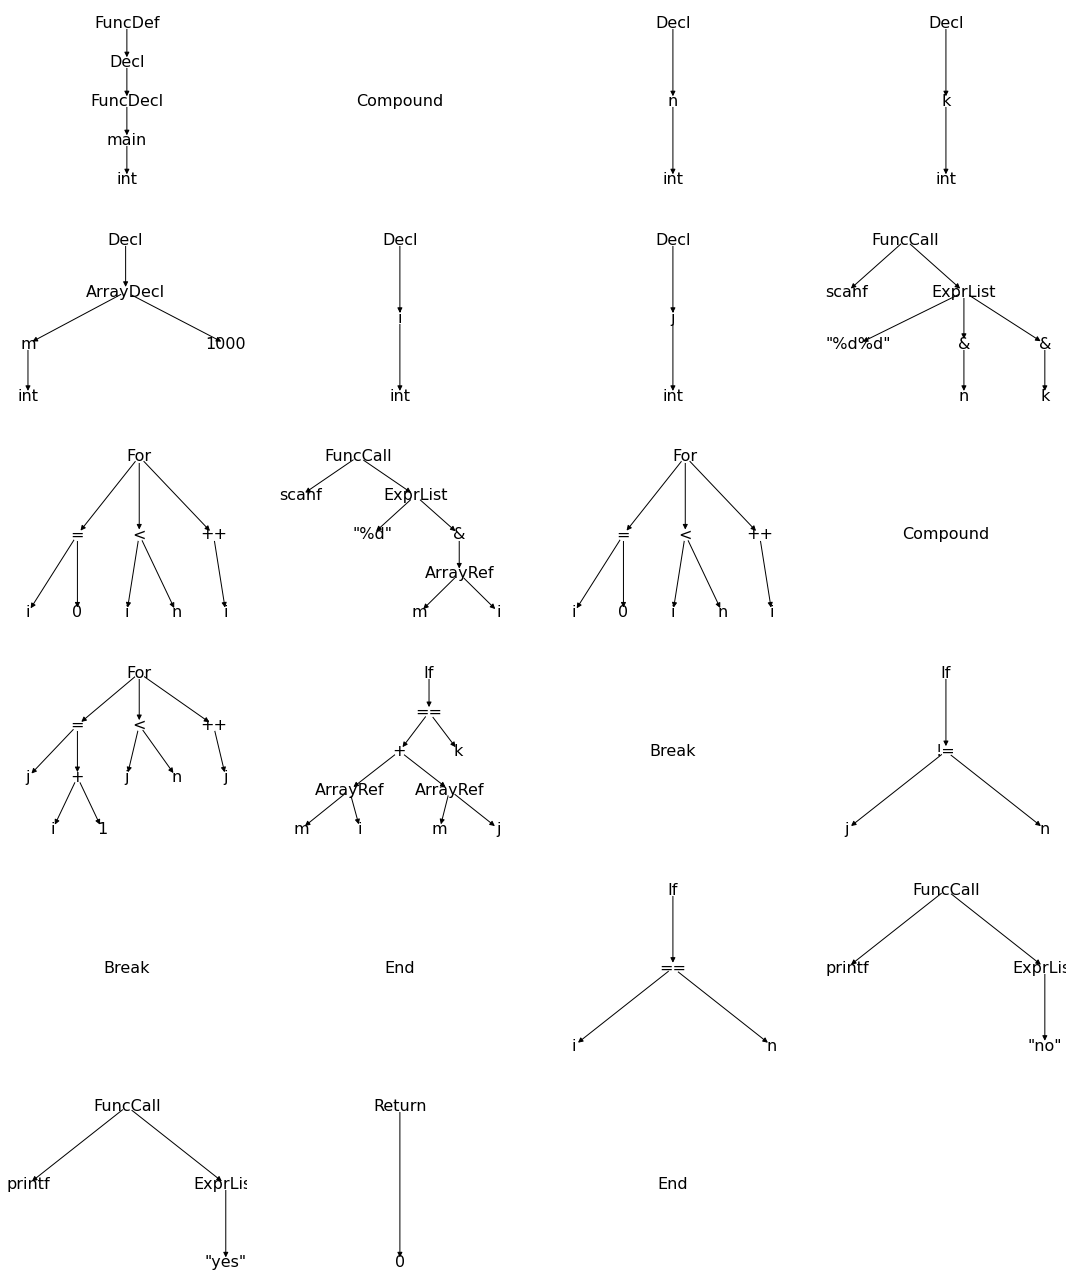

In [261]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

x, ast = block_data['code'][45281], ast_data['code'][45281]

_, orig_pred = torch.max(model([x]).data, 1)
orig_pred = orig_pred.item()

var_names = get_var_names(ast)
new_x_cos = gradient_method_2(x, var_names, 10, cos_sim)
new_x_l2 = gradient_method_2(x, var_names, 10, l2_norm)

plt.figure(figsize=(15,30))

options = {
    'node_color': 'white',
    'node_size': 100,
    'width': 1,
    'font_size': 16
}

token_blocks = []
for block in x:
    token_blocks.append(index_to_token(block))
    
for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)


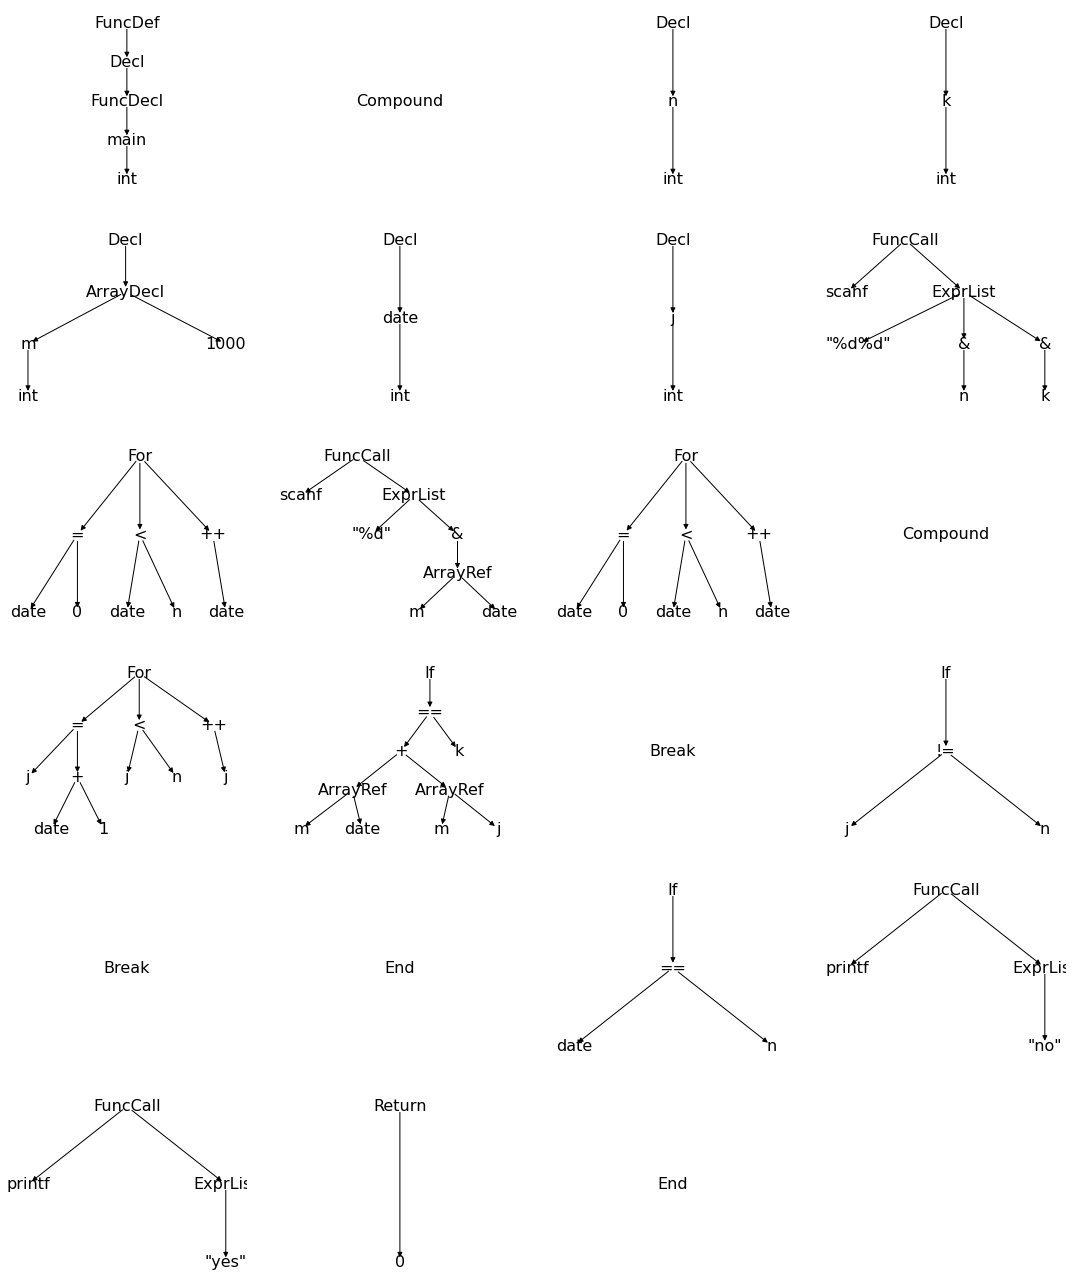

In [263]:
plt.figure(figsize=(15,30))

token_blocks = []
for block in new_x_l2:
    token_blocks.append(index_to_token(block))
    
for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)

## Gradient as heuristic

want to maximise l1 norm of the gradient

In [253]:
import heapq 

def gradient_method_2(x, var_names, epsilon, metric, rename_limit = len(var_names)):

    
    max_token = word2vec.vectors.shape[0]
    # get the grad
    loss_function = torch.nn.CrossEntropyLoss()
    labels = torch.LongTensor([orig_pred])
    output = model([x])
    loss = loss_function(output, Variable(labels))
    loss.backward()
    n_list = model._modules['encoder'].node_list
    
    prioritised_var_names = []
    for var in list(var_names):
        orig_index = vocab[var].index if var in vocab else max_token
        grad, node_embedding = get_grad(x, orig_index, n_list)
        if grad is not None:
            prioritised_var_names.append(((grad @ torch.sign(grad)).item(), var))
            
    prioritised_var_names.sort(reverse = True)
    i = 0
    for _, var in prioritised_var_names:
            
        orig_index = vocab[var].index if var in vocab else max_token
        grad, node_embedding = get_grad(x, orig_index, n_list)

        v = node_embedding.detach().numpy()
        g = torch.sign(grad).detach().numpy()

        v = v + epsilon * g
        i = closest_index(v, embedding_map, metric)
        x = replace_var(x, orig_index, i)
        i += 1
        if i >= rename_limit:
            break
    return x


In [257]:
ast_count = 0
ast_cos = 0
ast_l2 = 0
ast_total = 0

for code_id in block_data['id'].tolist():
    print(code_id)
    x, ast = block_data['code'][code_id], ast_data['code'][code_id]

    _, orig_pred = torch.max(model([x]).data, 1)
    orig_pred = orig_pred.item()
    
    var_names = get_var_names(ast)
    new_x_cos = gradient_method_2(x, var_names, 10, cos_sim, rename_limit = 5)
    new_x_l2 = gradient_method_2(x, var_names, 10, l2_norm, rename_limit = 5)
    
    o = model([new_x_cos])
    _, predicted_cos = torch.max(o.data, 1)
    o = model([new_x_l2])
    _, predicted_l2 = torch.max(o.data, 1)
    if predicted_cos.item() != orig_pred or predicted_l2.item() != orig_pred:    
        ast_count += 1
    if predicted_cos.item() != orig_pred:
        ast_cos += 1
    if predicted_l2.item() != orig_pred:
        ast_l2 += 1
    ast_total += 1

    print(ast_total, "AST level success:", ast_count / ast_total, ast_cos / ast_total, ast_l2 / ast_total)    
    if ast_total > 200:
        break


45281
1 AST level success: 1.0 1.0 0.0
40377
2 AST level success: 0.5 0.5 0.0
3220
3 AST level success: 0.3333333333333333 0.3333333333333333 0.0
20981
4 AST level success: 0.25 0.25 0.0
36621
5 AST level success: 0.2 0.2 0.0
29203
6 AST level success: 0.16666666666666666 0.16666666666666666 0.0
15031
7 AST level success: 0.14285714285714285 0.14285714285714285 0.0
26307
8 AST level success: 0.25 0.125 0.125
12163
9 AST level success: 0.2222222222222222 0.1111111111111111 0.1111111111111111
19003
10 AST level success: 0.2 0.1 0.1
14334
11 AST level success: 0.18181818181818182 0.09090909090909091 0.09090909090909091
13129
12 AST level success: 0.25 0.08333333333333333 0.16666666666666666
28713
13 AST level success: 0.23076923076923078 0.07692307692307693 0.15384615384615385
28620
14 AST level success: 0.21428571428571427 0.07142857142857142 0.14285714285714285
21417
15 AST level success: 0.2 0.06666666666666667 0.13333333333333333
8843
16 AST level success: 0.1875 0.0625 0.125
2377
17 

106 AST level success: 0.22641509433962265 0.03773584905660377 0.20754716981132076
9799
107 AST level success: 0.2336448598130841 0.037383177570093455 0.21495327102803738
1425
108 AST level success: 0.23148148148148148 0.037037037037037035 0.21296296296296297
39022
109 AST level success: 0.22935779816513763 0.03669724770642202 0.21100917431192662
24896
110 AST level success: 0.22727272727272727 0.03636363636363636 0.20909090909090908
10697
111 AST level success: 0.22522522522522523 0.036036036036036036 0.2072072072072072
33386
112 AST level success: 0.22321428571428573 0.03571428571428571 0.20535714285714285
2305
113 AST level success: 0.22123893805309736 0.035398230088495575 0.20353982300884957
42962
114 AST level success: 0.21929824561403508 0.03508771929824561 0.20175438596491227
29903
115 AST level success: 0.21739130434782608 0.034782608695652174 0.2
37663
116 AST level success: 0.22413793103448276 0.034482758620689655 0.20689655172413793
40806
117 AST level success: 0.22222222222

In [223]:
print("AST level success (Total, Cosine, L2 norm) :", ast_count / ast_total, ast_cos / ast_total, ast_l2 / ast_total)

AST level success (Total, Cosine, L2 norm) : 0.7860696517412935 0.24378109452736318 0.7661691542288557


## Adversarial example success rate (200 samples, renaming all variables)

### $\epsilon = 5$

### $\epsilon = 10$
AST level success (Total, Cosine, L2 norm) : 0.7860696517412935 0.24378109452736318 0.7661691542288557

### $\epsilon = 20$


## Adversarial example success rate (200 samples, renaming n variables based on heuristic)

### $\epsilon = 10, n=2$
AST level success: 0.263681592039801 0.03482587064676617 0.2537313432835821

### Example change

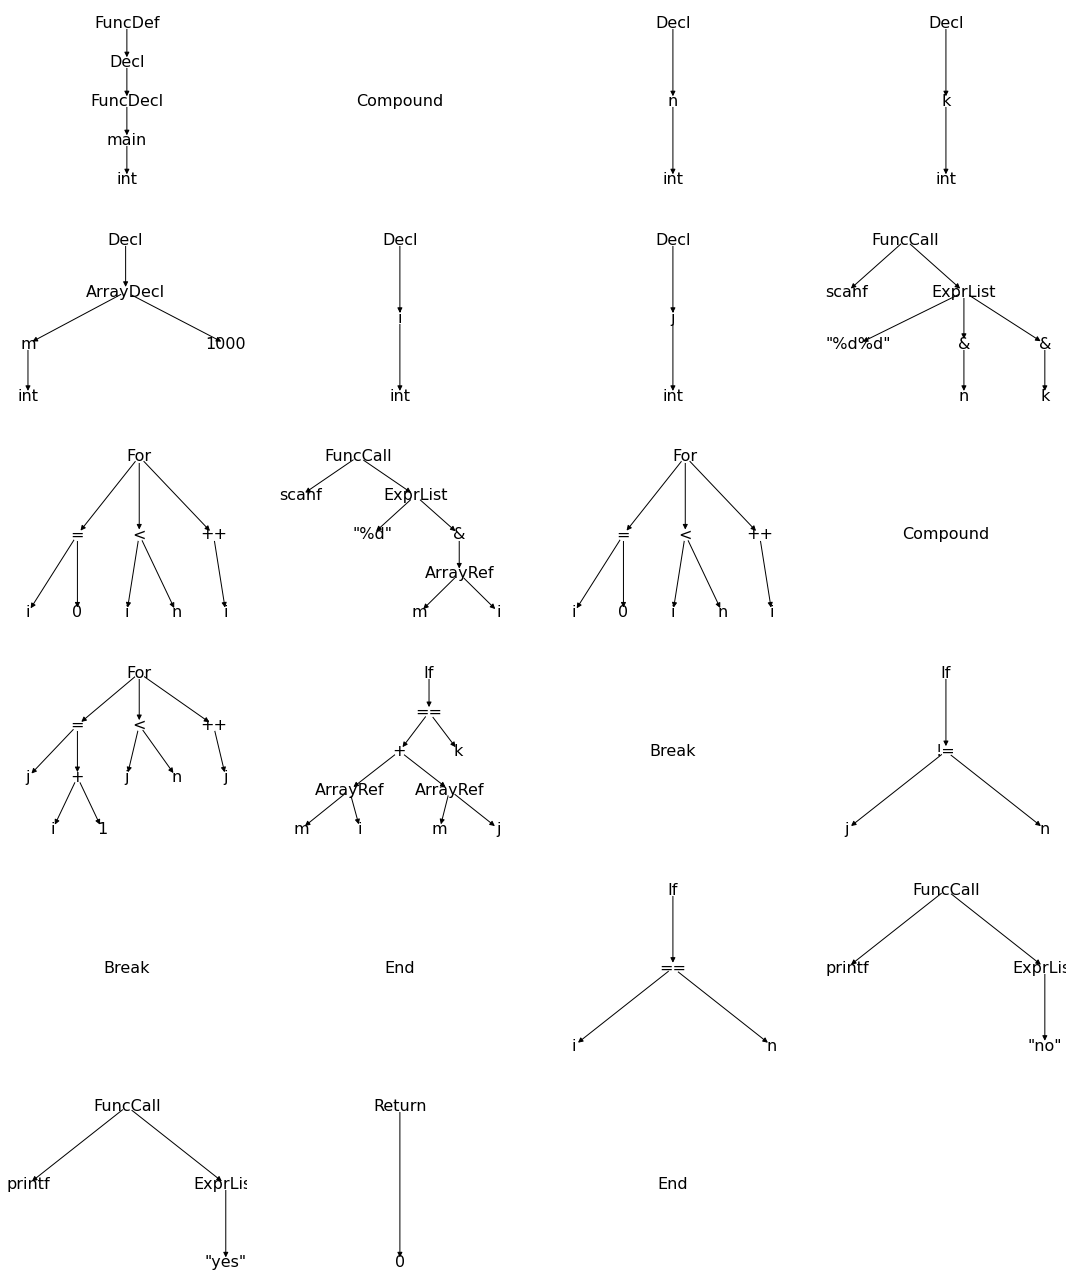

In [216]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

x, ast = block_data['code'][45281], ast_data['code'][45281]

_, orig_pred = torch.max(model([x]).data, 1)
orig_pred = orig_pred.item()

var_names = get_var_names(ast)
new_x_cos = gradient_method_2(x, var_names, 10, cos_sim)
new_x_l2 = gradient_method_2(x, var_names, 10, l2_norm)

plt.figure(figsize=(15,30))

options = {
    'node_color': 'white',
    'node_size': 100,
    'width': 1,
    'font_size': 16
}

token_blocks = []
for block in x:
    token_blocks.append(index_to_token(block))
    
for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)


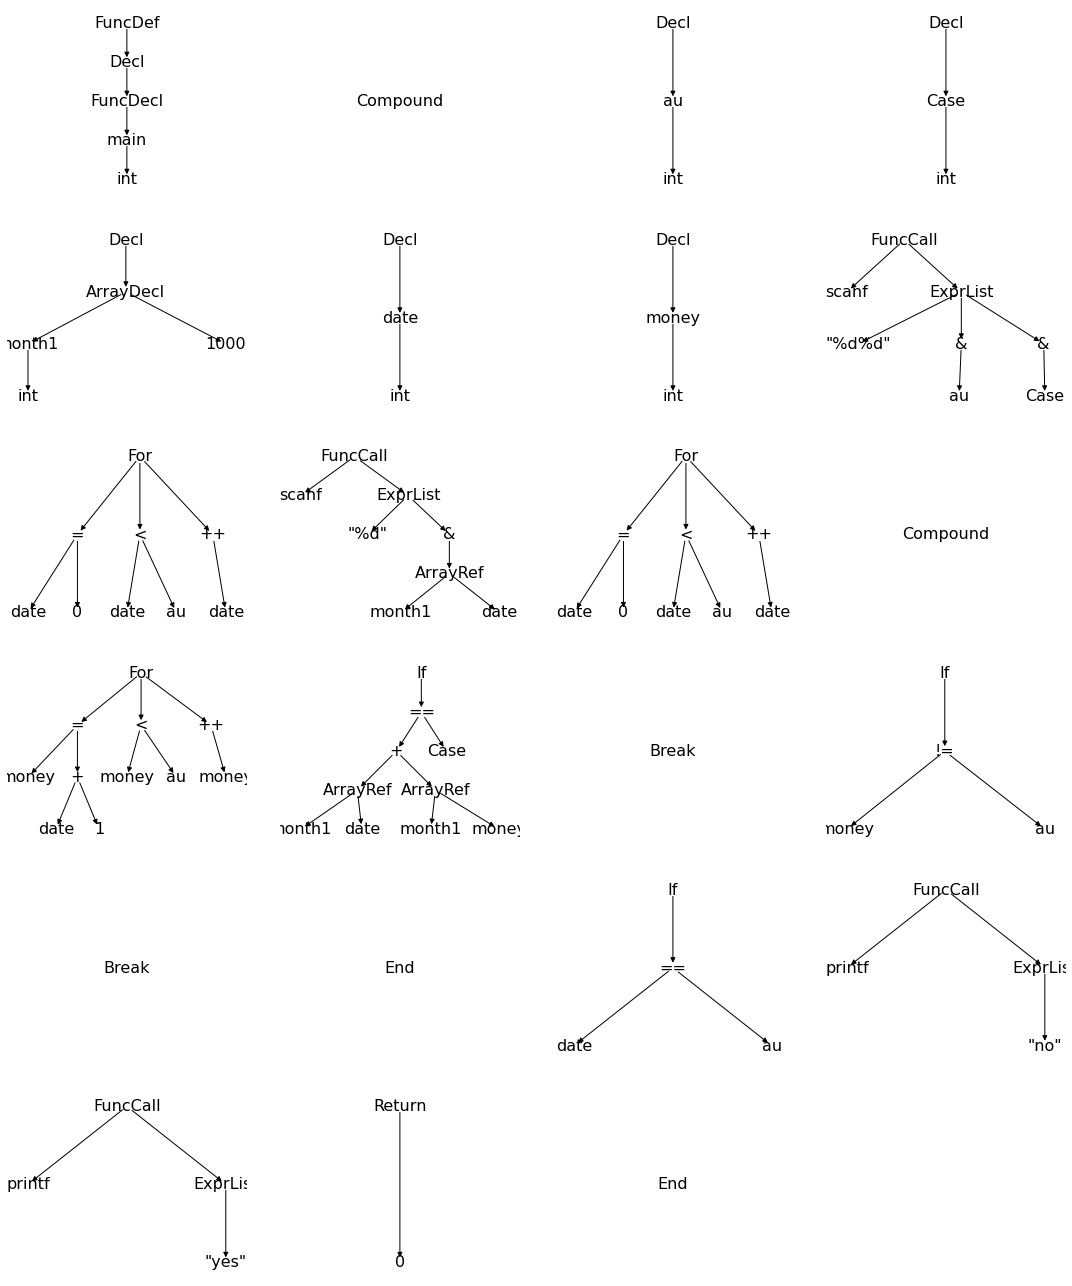

In [219]:
token_blocks = []
for block in new_x_l2:
    token_blocks.append(index_to_token(block))

plt.figure(figsize=(15,30))

for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)

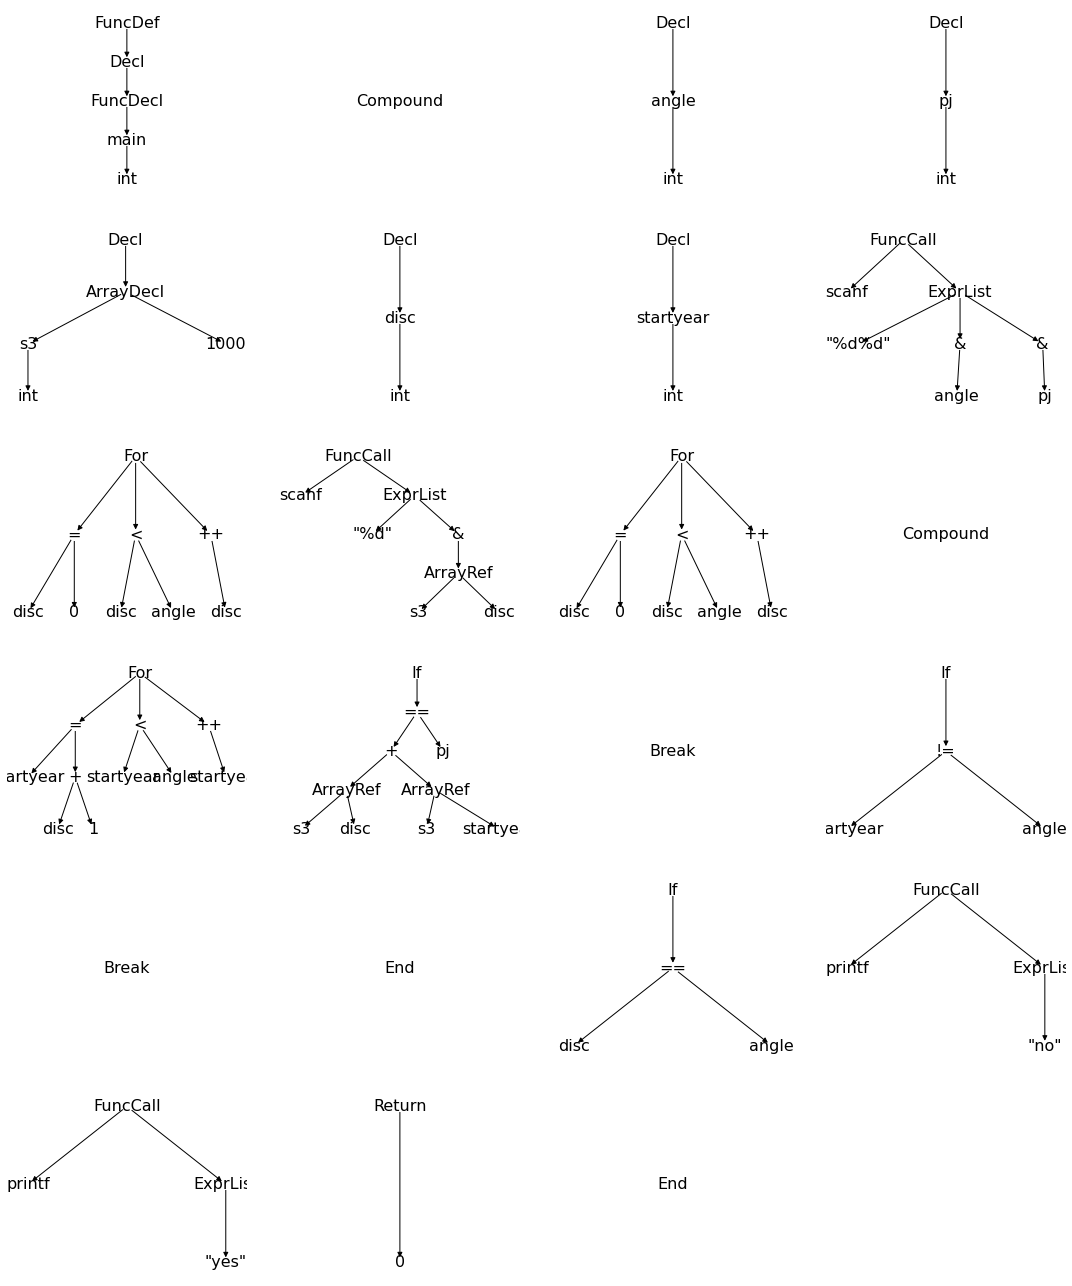

In [218]:
token_blocks = []
for block in new_x_cos:
    token_blocks.append(index_to_token(block))

plt.figure(figsize=(15,30))

for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)

# TODO 

reproduce prev results (renaming all tokens, not just variables) ~ Testing results(Acc): 0.3

# Training Accuracy

## No modifications

- Testing results(Acc): 0.9804826458994328

## Dead Code Additions

- 2 additions: Testing results(Acc): 0.9753869820209595
- 5 additions: Testing results(Acc): 0.9682722815113931


## Variable Renaming

- Testing results(Acc): 0.9478896259975003

## Combination

- Variable renaming, 5 dead code additions: Testing results(Acc): 0.9473127583886165
- Variable renaming, 10 dead code additions: Testing results(Acc): 0.946928179982694

# Efficiency Notes

## Variable renaming
- Test set (10401 code samples): ~1m 8s